Demonstrate frequency scanning using a simulated resonator.  

* kids.sweep() uses a single tone
* kids.set_tones() and kids.sweep_tones() first sets tones at nominal values, and the sweeps them all, using two tones:  one centered on the resonator and a second tone, off resonance.

These connections use "Dual 1" and "Sim 1" through 1-4 GHz Baluns

* DAC 2_230 --> 1-4 GHz Baluns --> ADC 2_227
* DAC 2_231 --> 1-4 GHz Baluns --> ADC 2_226

In [1]:
import sys
sys.path.append('../../../qick/qick_lib/')
sys.path.append('../soft/')
import Scan
from mkids import *
import matplotlib.pyplot as plt


In [2]:
board = Scan.getBoard()
if board == 'zcu111':
    bitfile = 'mkids_2x2_kidsim_v1'    
elif board == 'zcu216':
    bitfile = 'mkids_2x2_kidsim_v2'
else:
    raise Exception("Do not know what to do with %s"%board)
scan = Scan.Scan(bitfile, iKids=1, iSimu=1)

In [3]:
fMixerSimu = 3512
fMixerKids = 3700
fResonance = 3789.0123
fOffset = 12.3456
fc = 3790
df = 5 # Sweep Width
N = 250 # Number of points in a sweep

In [4]:
# Initialize simulation chain with one resonance
simu = scan.simuChain
simu.analysis.qout(3)
simu.synthesis.qout(3)
simu.alloff()

# Set mixer.
simu.set_mixer_frequency(fMixerSimu)

# Put one resonator 
print("fResonance = {} MHz".format(fResonance))
simu.enable(fResonance)

fResonance = 3789.0123 MHz


In [5]:
# Get the kids chain
kids = scan.kidsChain
qoutAnalysis = 2
qoutSynthesis = 2
kids.analysis.qout(2)
kids.synthesis.qout(2)


In [6]:
help(kids.sweep)

Help on method sweep in module mkids:

sweep(fstart, fend, N=10, g=0.5, decimation=2, set_mixer=True, verbose=False, showProgress=True, doProgress=False, doPlotFirst=False) method of mkids.KidsChain instance



In [7]:

f,a,phi=kids.sweep(fc-df/2,fc+df/2,N=N,g=0.9, showProgress=False, doProgress=True)

  0%|          | 0/250 [00:00<?, ?it/s]

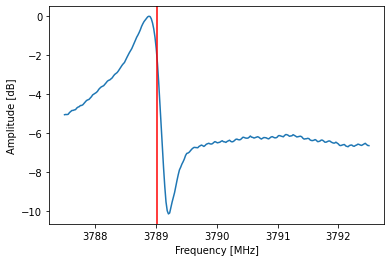

In [8]:
plt.plot(f,20*np.log10(a/max(a)))
plt.xlabel("Frequency [MHz]");
plt.ylabel("Amplitude [dB]");
plt.axvline(fResonance, c='r')

Text(0, 0.5, 'phase (Rad)')

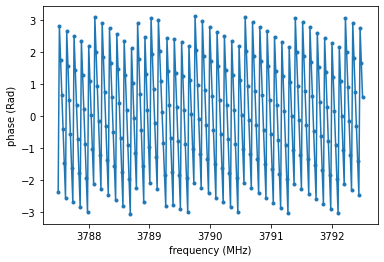

In [9]:
plt.plot(f,phi, '.-')
plt.xlabel("frequency (MHz)")
plt.ylabel("phase (Rad)")

In [10]:
kids.set_mixer_frequency(fMixerKids)

freqs = np.array([fResonance, fResonance+fOffset])
fis = np.array([0.1, 0.2])
gs = np.array([0.4, 0.6])
kids.set_tones(freqs, fis, gs)
xs = kids.sweep_tones(df, N, mean=True, doProgress=True)



  0%|          | 0/250 [00:00<?, ?it/s]

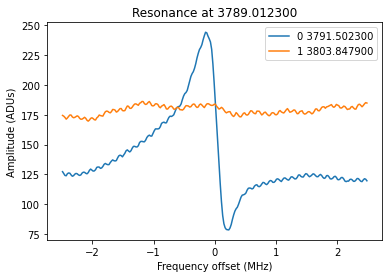

In [11]:
offsets = kids.get_sweep_offsets(df, N)

for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Amplitude (ADUs)")
plt.title("Resonance at %f"%fResonance)
plt.legend()


  0%|          | 0/250 [00:00<?, ?it/s]

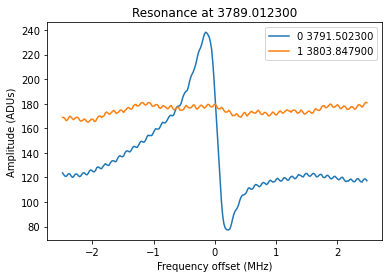

In [12]:
# Repeat the scan
kids.set_tones(freqs, fis, gs)
xs2 = kids.sweep_tones(df, N, mean=True, doProgress=True)
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs2[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Amplitude (ADUs)")
plt.title("Resonance at %f"%fResonance)
plt.legend()


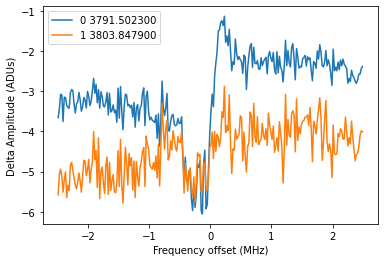

In [13]:
# Plot difference of first and second scan
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs2[:,iTone])-np.abs(xs[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Delta Amplitude (ADUs)")
plt.legend()


In [14]:
# Now turn off sumulated resonance and scan again
simu.alloff()
kids.set_tones(freqs, fis, gs)
xs3 = kids.sweep_tones(df, N, mean=True, doProgress=True)


  0%|          | 0/250 [00:00<?, ?it/s]

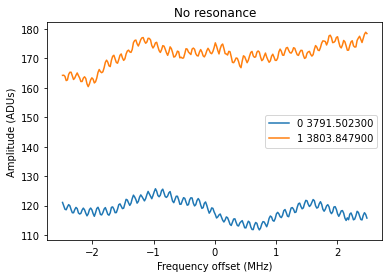

In [15]:
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.abs(xs3[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Amplitude (ADUs)")
plt.legend()
_ = plt.title("No resonance")


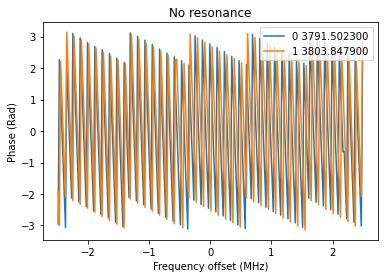

In [16]:
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(offsets, np.angle(xs3[:,iTone]), label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Phase (Rad)")
plt.legend()
_ = plt.title("No resonance")


In [17]:
delayFreqs = scan.inCh2Freq([9,10])
kids.set_tones(delayFreqs, fis, gs)
delayDf = .1
delayN = 20
delayOffsets = kids.get_sweep_offsets(delayDf, delayN)

xs4 = kids.sweep_tones(delayDf, delayN, mean=True, doProgress=True)


  0%|          | 0/20 [00:00<?, ?it/s]

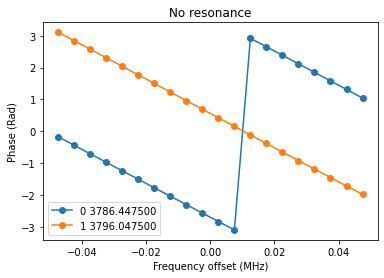

In [18]:
for iTone,qFreq in enumerate(kids.qFreqs):
    plt.plot(delayOffsets, np.angle(xs4[:,iTone]), "-o", label="%d %f"%(iTone,qFreq))
plt.xlabel("Frequency offset (MHz)")
plt.ylabel("Phase (Rad)")
plt.legend()
_ = plt.title("No resonance")


In [19]:
scan.inFreq2ch(freqs)

array([ 9, 11])